In [9]:
using Distributions
using Graphs, SimpleWeightedGraphs
using Plots
using Random
using StatsBase

function num(samples_in_columns::Matrix{Float64})
    return size(samples_in_columns)[2]
end

num (generic function with 1 method)

In [10]:
function probability(ρ::Float64, num_points::Int64, volume::Float64)
    return (ρ*volume)^num_points * exp(-ρ*volume) / factorial(big(num_points))
end


function log_probability(ρ::Float64, num_points::Int64, volume::Float64)
    return num_points * log((ρ*volume)) - ρ*volume - sum(log.(1:num_points))
end

log_probability (generic function with 1 method)

In [11]:
struct Rect
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
end

function standard_square()
    return Rect(-0.5, 0.5, -0.5, 0.5)
end

function get_volume(region::Rect)
    return (region.xmax - region.xmin) * (region.ymax - region.ymin)
end

function get_subrectangles(region::Rect, dx::Float64, dy::Float64)
    subrects = Rect[]
    for x in region.xmin:dx:(region.xmax - dx)
        for y in region.ymin:dy:(region.ymax - dy)
            push!(subrects, Rect(x, x+dy, y, y+dy))
        end
    end
    
    return subrects
end

get_subrectangles (generic function with 1 method)

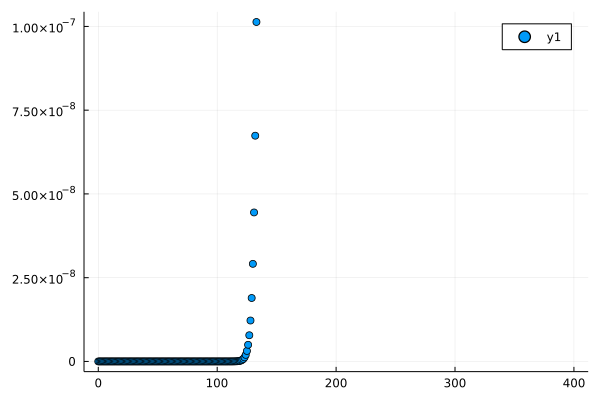

In [37]:
# Sprinkle within a unit square
square = Rect(-0.5, 0.5, -0.5, 0.5)
num_subsquares_across = 10
sub_sidelength = 1 / num_subsquares_across
subsquares = get_subrectangles(square, sub_sidelength, sub_sidelength)


function plot_sprinkling_distribution(ρ::Float64, volume::Float64, 
                                      max_number::Int64)
    dist = (n->probability(ρ, n, volume))

    
    n=0:max_number
    probs = (dist.(n))
#     probs[probs .> 1] .= 0

    return scatter(n,probs)
end

function plot_sprinkling_distribution(avg_num_points::Int64,  volume::Float64,
                                      max_number::Int64)
    ρ = avg_num_points / volume
    return plot_sprinkling_distribution(ρ, volume, max_number)
end


# plot_sprinkling_distribution(10000.0, sub_sidelength^2, 200)
plot_sprinkling_distribution(200, 0.01, 400)

In [13]:
function sample_num_points(ρ::Float64, volume::Float64, 
                           max_number::Int64)
    n = 1:max_number
    probs = (x->probability(ρ, x, volume)).(n)
    
    # I was getting infinite probabilites when the maximum number was too large,
    # so this is a quick fix.
    # TODO: Find a better way of ensuring the probabilities are reasonable
    probs[probs .> 1] .= 0
    
    return sample(n, Weights(probs))
end

function sample_num_points(avg_num_points::Int64, volume::Float64, 
                           max_number::Int64)
    ρ = avg_num_points / volume
    return sample_num_points(ρ, volume, max_number)
end

function draw_uniform_rectangle(region::Rect)
    return [rand(Distributions.Uniform(region.xmin, region.xmax));
            rand(Distributions.Uniform(region.ymin, region.ymax))]  
end

draw_uniform_rectangle (generic function with 1 method)

In [30]:
function sprinkle_region(region::Rect, ρ::Float64, max_number::Int64,
                         dx::Float64, dy::Float64)
    subregion = get_subrectangles(region, dx, dy)

    points = [[0.0; 0.0]]
    for sub in subregion
        num_points = sample_num_points(ρ, max_num, get_volume(sub))
        for n in 1:num_points
            push!(points, draw_uniform_rectangle(sub))
        end
    end
    
    return reduce(hcat, points)
end


function sprinkle_standard_square(expected_total_events::Int64, num_subsquares_across::Int64,
                                  sprinkling_distribution_upper_bound::Int64)
    square = standard_square()
    
    sub_sidelength = 1 / num_subsquares_across
    subsquares     = get_subrectangles(square, sub_sidelength, sub_sidelength)
    
    num_subsquares   = num_subsquares_across^2
    subsquare_volume = 1 / num_subsquares

    expected_events_per_subsquare = expected_total_events         / num_subsquares
    expected_subsquare_density    = expected_events_per_subsquare / subsquare_volume
    print(subsquare_volume)

    points = [[0.0; -0.5], 
              [0.25; 0.5]]
    
    for sub in subsquares
        num_points = sample_num_points(expected_subsquare_density, get_volume(sub), sprinkling_distribution_upper_bound)
        for n in 1:num_points
            push!(points, draw_uniform_rectangle(sub))
        end
    end
    
    return reduce(hcat, points)
end    

sprinkle_standard_square (generic function with 1 method)

In [31]:
function causal_distance(vector_A2B::Vector{Float64})
    η = [1 0; 0 -1.]
    return vector_A2B' * η * vector_A2B
end

function causal_distance(pointA::Vector{Float64}, pointB::Vector{Float64})
    vector_A2B = pointB - pointA
    return causal_distance(vector_A2B)
end


function euclid_distance(pointA::Vector{Float64}, pointB::Vector{Float64})
    η = [1 0; 0 1]
    diff = pointB - pointA
    return diff' * η * diff
end

function make_causal_set(sprinkled_points::Matrix{Float64})
    num_points = size(sprinkled_points)[2]
    
    causal_set = SimpleWeightedDiGraph(num_points)
    for i = 1:num_points
        for j = 1:num_points
            vector_i2j = sprinkled_points[:, j] - sprinkled_points[:, i]
            interval = causal_distance(vector_i2j)
            
            if  interval <= 0 && vector_i2j[2] > 0
                add_edge!(causal_set, i, j, -1.0)
            end
        end
    end 
            
    return causal_set
end

function longest_path(graph, source::Int64, destination::Int64)
    return enumerate_paths(dijkstra_shortest_paths(graph, source), destination)
end
    

longest_path (generic function with 1 method)

In [32]:
expected_total_events = 200
num_subsquares_across = 1

@time sprinkling = sprinkle_standard_square(expected_total_events, num_subsquares_across, 2*expected_total_events)
@time causal_set = make_causal_set(sprinkling)
num_points = nv(causal_set)
print("Created a causal set with ", num_points, " events.\n")

# @time worldline_indices = longest_path(causal_set, 1, 2)
# worldline = sprinkling[:, worldline_indices];

# print(length(worldline))

1.0  0.000897 seconds (5.16 k allocations: 270.531 KiB)
  0.028836 seconds (176.93 k allocations: 12.130 MiB, 54.11% gc time)
Created a causal set with 133 events.


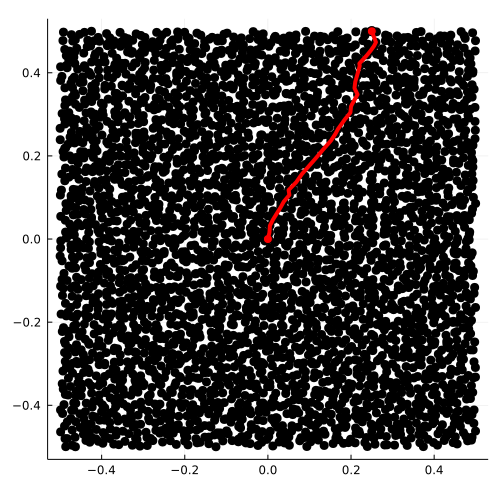

In [131]:
colors = repeat([:black], num_points)
colors[1:2] .= :red

scatter(sprinkling[1, :], sprinkling[2,:], ms=5, legend=nothing, color=colors,
        size=(500,500), aspect_ratio=1, xlim=[-0.5,0.5], ylim=[-0.5,0.5])
scatter!(sprinkling[1, 1:2], sprinkling[2, 1:2], ms=5, color=:red)

plot!(worldline[1, :], worldline[2,:], lw=4, color=:red)


In [135]:
function maximal_chain_length(destination::Vector{Float64}, density::Float64, 
                              max_number::Int64, num_subsquares_across::Int64)
    
end

maximal_chain_length (generic function with 1 method)

3-element Vector{Int64}:
  1
 28
 34